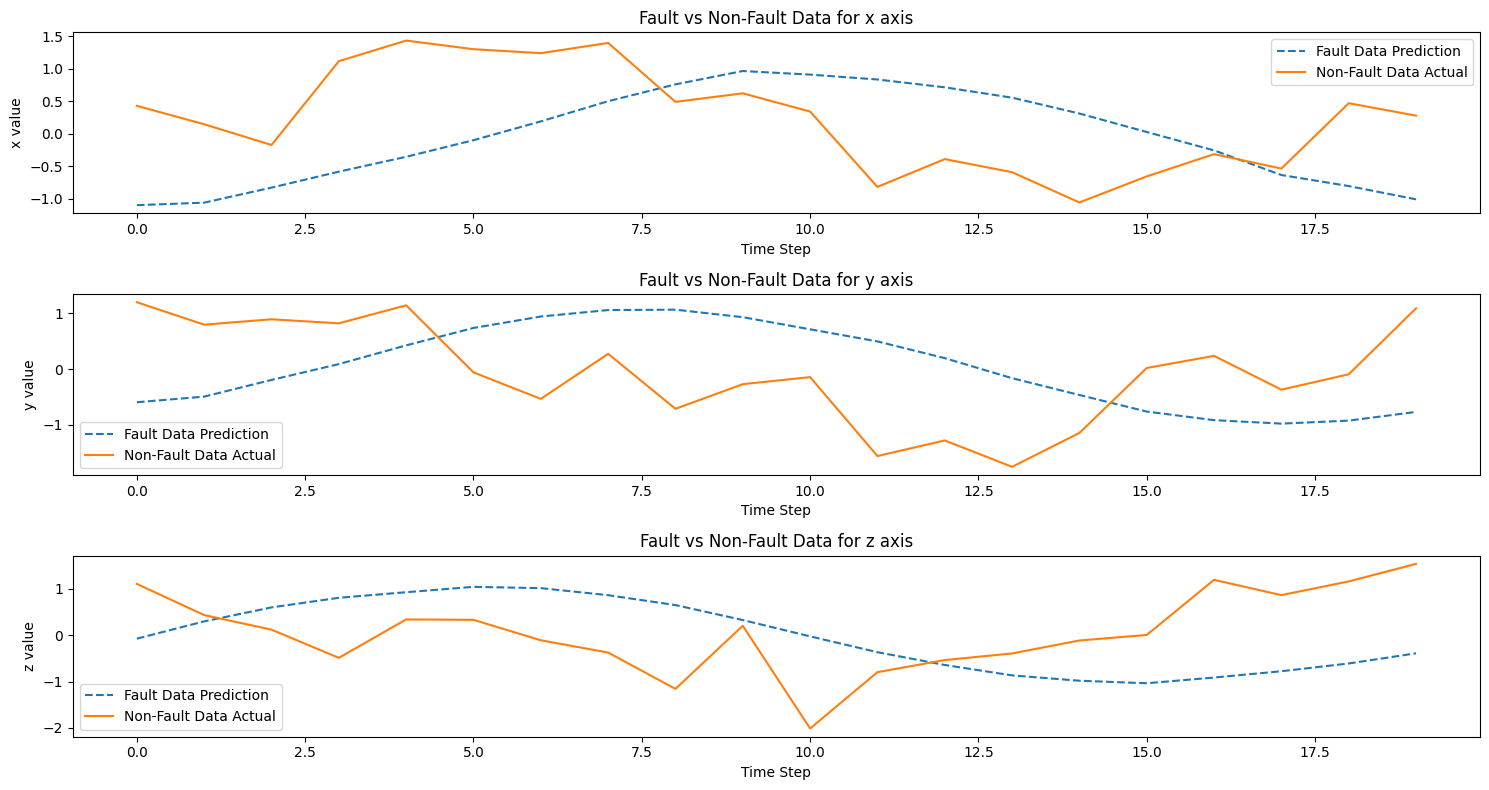

In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=50, output_size=3 * 20):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Get the output of the last time step
        x = self.fc(x)
        return x

# Initialize model, criterion, and optimizer
input_length = 80
output_length = 20
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load the data
def load_data(file_path, input_length=80, output_length=20):
    data = pd.read_csv(file_path)
    sequences = []
    for i in range(len(data) - (input_length + output_length)):
        sequence = data.iloc[i:i + input_length + output_length][['x', 'y', 'z']].values
        sequences.append(sequence)

    inputs = [seq[:input_length] for seq in sequences]
    targets = [seq[input_length:] for seq in sequences]
    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32).reshape(len(sequences), -1)
    return TensorDataset(inputs, targets)

# Predict function
def predict(model, dataset):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            outputs = model(inputs)
            predictions.append(outputs.view(-1, 3).numpy())  # Reshape for plotting

    return np.concatenate(predictions, axis=0)

# Plot comparison
def plot_comparison(fault_predictions, non_fault_data):
    plt.figure(figsize=(15, 8))
    for i, axis in enumerate(['x', 'y', 'z']):
        plt.subplot(3, 1, i + 1)
        plt.plot(fault_predictions[:, i], label='Fault Data Prediction', linestyle='--')
        plt.plot(non_fault_data[-len(fault_predictions):, i], label='Non-Fault Data Actual', linestyle='-')
        plt.title(f'Fault vs Non-Fault Data for {axis} axis')
        plt.xlabel('Time Step')
        plt.ylabel(f'{axis} value')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Load model state
model_path = '/Users/prasanna/Desktop/Hack2Future/lstm_model.pth'
model.load_state_dict(torch.load(model_path))

# Load datasets
fault_data_file = "/Users/prasanna/Desktop/Hack2Future/lagger.csv"  # Fault data path
non_fault_data_file = "/Users/prasanna/Desktop/Hack2Future/non_fault_data.csv"  # Non-fault data path
fault_dataset = load_data(fault_data_file, input_length, output_length)
non_fault_dataset = load_data(non_fault_data_file, input_length, output_length)

# Make predictions
fault_predictions = predict(model, fault_dataset)
non_fault_data = pd.read_csv(non_fault_data_file)[['x', 'y', 'z']].values

# Plot comparison of the last 20 entries
plot_comparison(fault_predictions[-20:], non_fault_data)
